# Importing Necessary Package

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

# Download Dataset from Kaggle

In [2]:
!pip install -q kaggle

In [3]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imadedwipayana","key":"c997969937d91fea2916d65abe6bc451"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d cornflake15/denpasarbalihistoricalweatherdata

  0% 0.00/7.32M [00:00<?, ?B/s]
100% 7.32M/7.32M [00:00<00:00, 67.7MB/s]


In [6]:
!mkdir dataset
!unzip denpasarbalihistoricalweatherdata.zip -d dataset
!ls dataset

Archive:  denpasarbalihistoricalweatherdata.zip
  inflating: dataset/openweatherdata-denpasar-1990-2020.csv  
  inflating: dataset/openweatherdata-denpasar-1990-2020v0.1.csv  
openweatherdata-denpasar-1990-2020.csv
openweatherdata-denpasar-1990-2020v0.1.csv


# Manipulating Dataset

In [9]:
usecols = ['dt_iso', 'temp']
df = pd.read_csv('dataset/openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=True, index_col='dt_iso', usecols=usecols)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264924 entries, 1990-01-01 00:00:00 to 2020-01-07 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    264924 non-null  float64
dtypes: float64(1)
memory usage: 4.0 MB


,temp
dt_iso,
1990-01-01 00:00:00,25.82
1990-01-01 01:00:00,26.20
1990-01-01 02:00:00,26.45
1990-01-01 03:00:00,26.80
1990-01-01 04:00:00,27.04


In [10]:
# checking null
df.isnull().sum()

temp    0
dtype: int64

In [11]:
df.head()

,temp
dt_iso,
1990-01-01 00:00:00,25.82
1990-01-01 01:00:00,26.20
1990-01-01 02:00:00,26.45
1990-01-01 03:00:00,26.80
1990-01-01 04:00:00,27.04


In [12]:
df = df.resample('D').mean()
df.index.names =['date']
df.reset_index(level=0, inplace=True)

In [13]:
df.head()

,date,temp
0,1990-01-01,26.333750
1,1990-01-02,25.559583
2,1990-01-03,26.956667
3,1990-01-04,26.638750
4,1990-01-05,27.940417


# Modeling and Evaluation

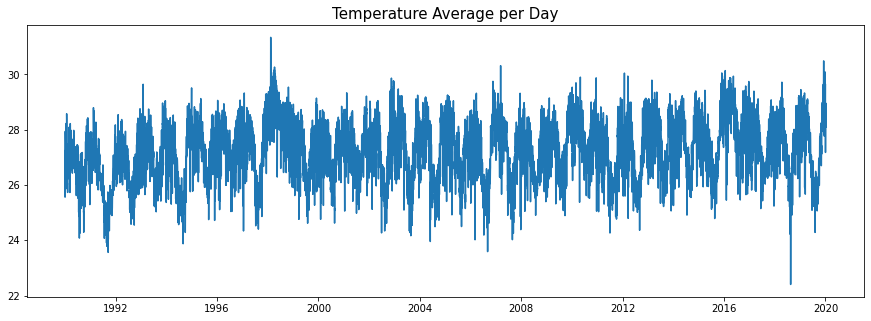

In [14]:
dates = df['date'].values
temp  = df['temp'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature Average per Day',
          fontsize=15);

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

8771 2193


In [17]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [19]:
THRESOLD = (df['temp'].max() - df['temp'].min()) * 10/100 #10%
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < THRESOLD):
      self.model.stop_training = True
      print("\nStop")

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set ,epochs=500, validation_data=test_set, callbacks=[Callback()])

Epoch 1/500
88/88 [==============================] - 17s 138ms/step - loss: 25.7684 - mae: 26.2684 - val_loss: 25.3641 - val_mae: 25.8641
Epoch 2/500
88/88 [==============================] - 11s 121ms/step - loss: 23.9609 - mae: 24.4609 - val_loss: 23.0634 - val_mae: 23.5634
Epoch 3/500
88/88 [==============================] - 11s 122ms/step - loss: 20.3776 - mae: 20.8777 - val_loss: 17.6115 - val_mae: 18.1115
Epoch 4/500
88/88 [==============================] - 12s 132ms/step - loss: 10.8652 - mae: 11.3651 - val_loss: 1.7064 - val_mae: 2.1847
Epoch 5/500
88/88 [==============================] - 11s 127ms/step - loss: 0.4722 - mae: 0.8615 - val_loss: 0.5087 - val_mae: 0.9078

Stop


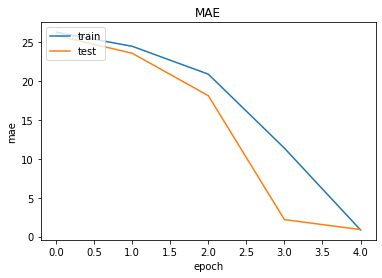

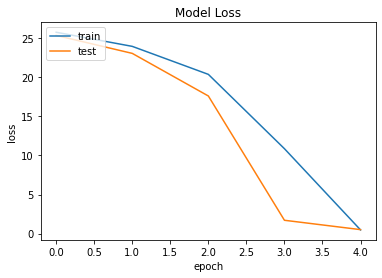

In [21]:
# plotting MAE
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()